# WIDS Datathon 2021: Predicting Diabetes 
By *GirlsGoneWireless*: Ana Parra Vera   |   Elda Pere


## ✏️ Pre-processing

### Import Libraries

In [ ]:
pip install octopus-ml

In [ ]:
import pandas as pd
import numpy as np
from google.colab import (drive, files)
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns
import octopus_ml as oc

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [ ]:
# connect to the drive
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive"
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
# ana
% ls MyDrive/Data\ Science/WIDS\ Datathon/DATA

ls: cannot access 'MyDrive/Data Science/WIDS Datathon/DATA': No such file or directory


In [ ]:
# elda
% ls MyDrive/Projects/WIDS\ Datathon

 DATA/
 DataDictionaryWiDS2021.gsheet
 GirlsGoneWireless_v4.ipynb
 GirlsGoneWireless_v5.ipynb
 GirlsGoneWireless_v6.ipynb
 GirlsGoneWireless_v7.ipynb
 GirlsGoneWireless_v8.ipynb
 GirlsGoneWireless_v9.ipynb
 Notes.gdoc
'Prev Notebooks'/
 Research.gdoc
 TrainTestSplitAndCrossValidation.ipynb
'Webinar Notes.gdoc'
 wids2021-initial-eda-and-tuned-lgbm-0-86269.ipynb
'WIDs changes.gsheet'
 wids_eda.html
 WIDS_EDA.ipynb


In [ ]:
## choose appropriate path and uncomment below

filepath = 'MyDrive/Projects/WIDS Datathon/DATA/'
# filepath = 'MyDrive/Data Science/WIDS Datathon/DATA/'

### Read the Data

In [ ]:
wids_train_df = pd.read_csv(filepath+'TrainingWiDS2021.csv',index_col=0)

In [ ]:
wids_test_df = pd.read_csv(filepath+'UnlabeledWiDS2021.csv',index_col=0)

### Data Preview

In [ ]:
# checking the columns are the same in the train and test dfs
test_cols = wids_test_df.columns.tolist()
train_cols = wids_train_df.columns.tolist()
train_cols.remove('diabetes_mellitus')

# sanity check
train_cols == test_cols

True

In [ ]:
# we should see 130,157 encounters represented here
wids_train_df.shape

(130157, 180)

In [ ]:
# preview of the data
wids_train_df.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


## 📊 EDA


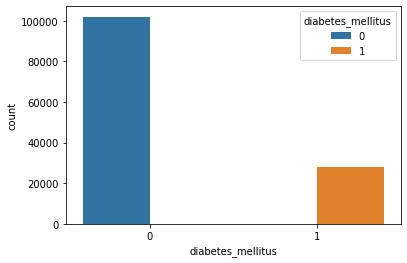

In [ ]:
# distribution of target class (diabetes_mellitus)
sns.countplot(x="diabetes_mellitus", data=wids_train_df, hue="diabetes_mellitus")

<Figure size 576x216 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Diabetes class')

Text(0, 0.5, 'Count')

[]

[Text(0, 0, 'No Diabetes'), Text(0, 0, 'Diabetes')]

Text(-0.04999999999999999, 102010, '102011')

Text(0.95, 28155, '28156')

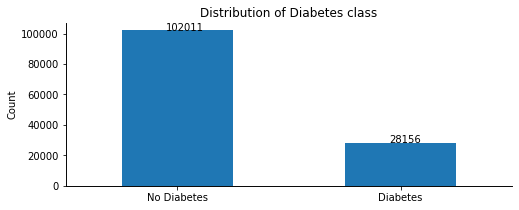

In [ ]:
plt.figure(figsize=(8,3))

plt.title('Distribution of Diabetes class')
plt.ylabel('Count')

# create barplot based on counts of diabetes class
ax = (wids_train_df.diabetes_mellitus.value_counts()).sort_index().plot(kind="bar", rot=0)

ax2 = ax.twinx()
sns.despine(right=True) # remove right y-axis
ax2.set_yticks([]) # remove right y ticks
ax.set_xticklabels(['No Diabetes', 'Diabetes'])

# add count numbers to the top of each bar
for p in ax.patches:
    ax.annotate('{:d}'.format(p.get_height()+5), (p.get_x()+0.2, p.get_height()+4))

<Figure size 720x288 with 0 Axes>

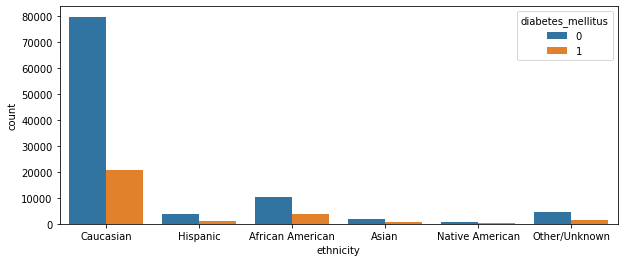

In [ ]:
# distribution of ethnicity
plt.figure(figsize=(10,4))
sns.countplot(x="ethnicity", data=wids_train_df, hue="diabetes_mellitus")

In [ ]:
def plot_var_counts(df, col, title=None):
  """
  Plotting distributions for cases with diabetes vs. cases with no diabetes.
  """
  plt.figure(figsize=(8,3))

  # create each plot
  sns.distplot(df[df.diabetes_mellitus==1][col], kde=False, label="Diabetes")
  sns.distplot(df[df.diabetes_mellitus==0][col], kde=False, label="No Diabetes")

  # plot formatting
  plt.legend()
  plot_title = 'Distribution of ' + col.capitalize()
  plt.title(plot_title)
  plt.ylabel('Count')


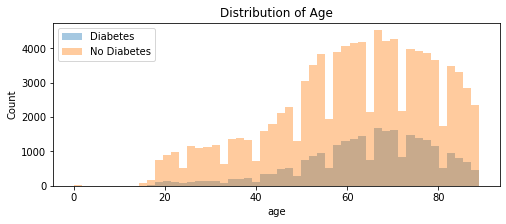

In [ ]:
plot_var_counts(wids_train_df, 'age')

In [ ]:
# there are ages of 0 - must be a data error
wids_train_df['age'].describe()

count    125169.000000
mean         61.995103
std          16.822880
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          89.000000
Name: age, dtype: float64

In [ ]:
# there are ages of 0 - must be a data error
wids_train_df[wids_train_df['age']==0].shape

(30, 180)

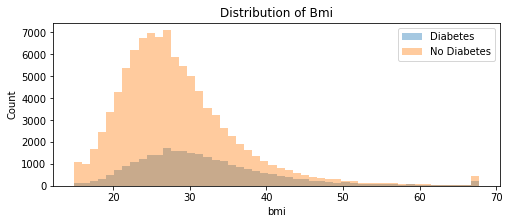

In [ ]:
plot_var_counts(wids_train_df, 'bmi')


In [ ]:
# count of male vs. female patients
wids_train_df.gender.value_counts(dropna=False)

M      70518
F      59573
NaN       66
Name: gender, dtype: int64

In [ ]:
# count of male vs. female for patients with diabetes
wids_train_df[wids_train_df.diabetes_mellitus==1].gender.value_counts(dropna=False)

M      15420
F      12726
NaN        5
Name: gender, dtype: int64

In [ ]:
# percentage of males with diabetes
15420/70518*100

21.866757423636518

In [ ]:
# percentage of females with diabetes
12726/59573*100

21.362026421365385

<Figure size 576x216 with 0 Axes>

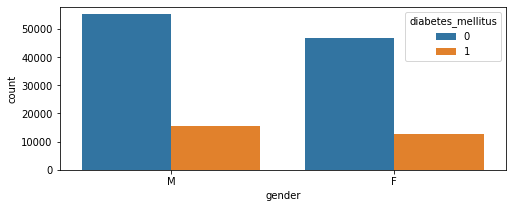

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(x="gender", data=wids_train_df, hue="diabetes_mellitus")

In [ ]:
# stats for height (unit is cm)
wids_train_df.height.describe()

count    128080.000000
mean        169.607219
std          10.833085
min         137.200000
25%         162.500000
50%         170.100000
75%         177.800000
max         195.590000
Name: height, dtype: float64

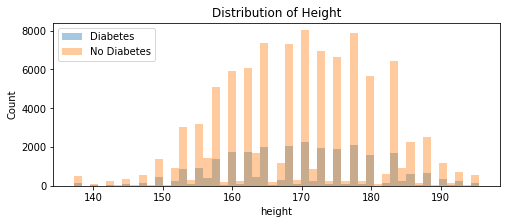

In [ ]:
plot_var_counts(wids_train_df, 'height')


<Figure size 576x216 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Height for Male vs. Female')

Text(0, 0.5, 'Count')

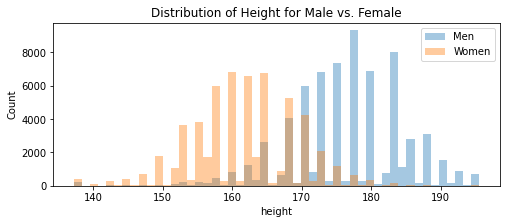

In [ ]:
# plotting height vs gender - men tend to be taller
plt.figure(figsize=(8,3))

# create each plot
sns.distplot(wids_train_df[wids_train_df.gender=='M']['height'], kde=False, label="Men")
sns.distplot(wids_train_df[wids_train_df.gender=='F']['height'], kde=False, label="Women")

# plot formatting
plt.legend()
plot_title = 'Distribution of Height for Male vs. Female'
plt.title(plot_title)
plt.ylabel('Count')


In [ ]:
# readmission status is blank
wids_train_df.readmission_status.value_counts()

0    130157
Name: readmission_status, dtype: int64

In [ ]:
# count of arf_apache - whether the patient had acute renal failure 
# during the first 24 hours of their unit stay, defined as a 24 hour 
# urine output <410ml, creatinine >=133 micromol/L and no chronic dialysis
wids_train_df.arf_apache.value_counts()

0    126513
1      3644
Name: arf_apache, dtype: int64

In [ ]:
cols_for_corr = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 
                'gcs_verbal_apache', 'hepatic_failure', 'immunosuppression', 
                'intubated_apache', 'paco2_apache', 'paco2_for_ph_apache', 
                'ph_apache', 'age', 'apache_3j_diagnosis', 'arf_apache', 'bmi', 
                'cirrhosis', 'gender', 'height', 'icu_type', 
                'urineoutput_apache', 'weight', 'pre_icu_los_days', 'ethnicity',
                'elective_surgery', 'icu_admit_source', 'icu_stay_type', 
                'diabetes_mellitus']

<Figure size 864x576 with 0 Axes>

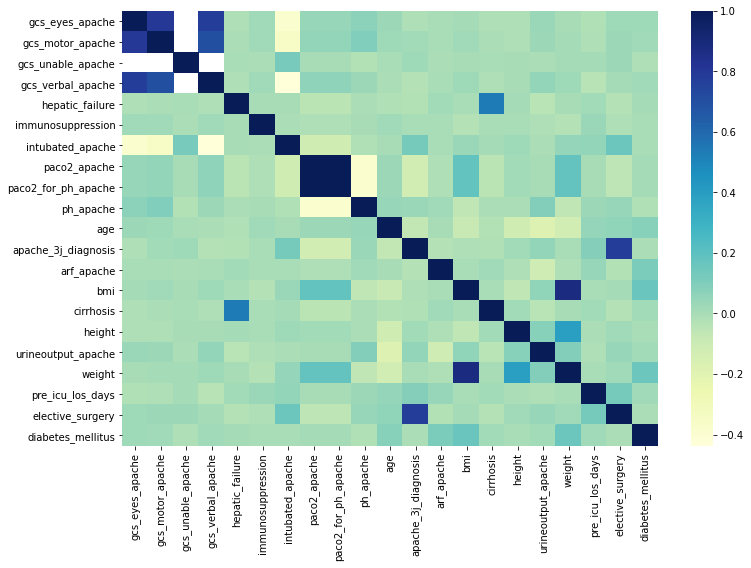

In [ ]:
# calculate correlations
diabetes_correlations = wids_train_df[cols_for_corr].corr()

# plot correlations
plt.figure(figsize=(12,8))
sns.heatmap(diabetes_correlations, xticklabels=diabetes_correlations.columns, 
            yticklabels=diabetes_correlations.columns, cmap="YlGnBu")

In [ ]:
diabetes_correlations['diabetes_mellitus'].sort_values()

ph_apache             -0.020751
gcs_unable_apache     -0.012756
apache_3j_diagnosis   -0.009536
elective_surgery      -0.004910
height                -0.004302
immunosuppression     -0.003022
intubated_apache      -0.000318
paco2_apache           0.007982
paco2_for_ph_apache    0.007982
hepatic_failure        0.009535
urineoutput_apache     0.014848
cirrhosis              0.015179
gcs_verbal_apache      0.020166
pre_icu_los_days       0.022141
gcs_motor_apache       0.023133
gcs_eyes_apache        0.023841
age                    0.081019
arf_apache             0.108469
weight                 0.155517
bmi                    0.169043
diabetes_mellitus      1.000000
Name: diabetes_mellitus, dtype: float64

## ⚙️ Feature Engineering



### Fix Data Types

In [ ]:
def fix_data_types(cat_cols, bin_cols, num_cols, df):
  df.loc[:,cat_cols] = df.loc[:,cat_cols].astype('category')
  df.loc[:,bin_cols] = df.loc[:,bin_cols].astype(bool)
  # print(df[num_cols].dtypes.nunique())
  return df

### Missing Values

Below we fix data types and deal with missing values, removing the variables with more than 90% missing cells, and imputing the remaining quantitative variables. The missing values are imputed when the model is trained. 

In [ ]:
def remove_percent_missing(df, pct=0.99):
  for i in df.columns:
    percent_missing = df[[i]].isnull().sum()/df.shape[0]
    if percent_missing[0] > pct:
      df.drop(columns = [i], inplace=True)
      # print("dropped",i)
  return df

### Calculated BMI

Due to the discrepancies between the values of the BMI variable and the BMI values we calculated using height and weight data, we chose to add the calculated BMI as a variable, as well as the difference between the two so that it may capture a patient's body changes in the cases when the given BMI was taken a long time ago. 

In [ ]:
def add_bmi(df):
  # add calculated BMI variable to dataframe
  df["calculated_bmi"] = df['weight']/(df["height"]/100)**2

  # add difference of BMI and calculated BMI as variable
  df["bmi_difference"] = df["bmi"] - df["calculated_bmi"]

  # add additional columns with nonlinear transformations of bmi
  #df["bmi_squared"] = df["bmi"]**2 NVM BAD

  #df["bmi_log"] = np.log(df["bmi"]) NVM BAD

  return df

### BMI by Ethnicity and Gender

After speaking to medical professionals and researching the relationship between BMI and diabetes, we found that much of the bias in machine learning models come from using the standard white male BMI as a feature. Below, we added BMI values for overweight and obese diabetic individuals categorized by the ethnicities and genders given in the training data.

The BMI values were taken from the [Supplementary Data](https://care.diabetesjournals.org/content/diacare/suppl/2019/09/03/dc19-0532.DC1/DC190532SupplementaryData.pdf) of the [journal](https://care.diabetesjournals.org/content/42/12/2211) *Racial/Ethnic Disparities in the Prevalence of Diabetes and Prediabetes by BMI: Patient Outcomes Research To Advance Learning (PORTAL) Multisite Cohort of Adults in the U.S.* by Yeyi Zhu, Margo A. Sidell, David Arterburn, Matthew F. Daley, Jay Desai, Stephanie L. Fitzpatrick, Michael A. Horberg, Corinna Koebnick, Emily McCormick, Caryn Oshiro, Deborah R. Young, and Assiamira Ferrara.

In [ ]:
def gender_ethnicity_overweight(df):
  """
  Calculating whether a patient is considered overweight based on their BMI,  
  gender and ethnicity.
  """
  if df['gender'] == 'F':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >= 7.8 and df['calculated_bmi'] < 14.1
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 15.9 and df['calculated_bmi'] < 21.2
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 16.6 and df['calculated_bmi'] < 23.4
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 16.4 and df['calculated_bmi'] < 24.9
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >= 14.1 and df['calculated_bmi'] < 21.4
    else:
      return df['calculated_bmi'] >= 11.8 and df['calculated_bmi'] < 18.4
  
  elif df['gender'] == 'M':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >= 10.9 and df['calculated_bmi'] < 18.6
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 20.0 and df['calculated_bmi'] < 27.1
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 21.2 and df['calculated_bmi'] < 27.9
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 20.5 and df['calculated_bmi'] < 28.0
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >= 17.2 and df['calculated_bmi'] < 24.6
    else:
      return df['calculated_bmi'] >= 15.0 and df['calculated_bmi'] < 22.6
  else:
    return np.nan 

def gender_ethnicity_obese(df):
  """
  Calculating whether a patient is considered obese based on their BMI,  
  gender and ethnicity.
  """
  if df['gender'] == 'F':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >= 14.1
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 21.2
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 23.4
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 24.9
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >= 21.4
    else:
      return df['calculated_bmi'] >= 18.4
  
  elif df['gender'] == 'M':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >=  18.6
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 27.1
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 27.9
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 28.0
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >=  24.6
    else:
      return df['calculated_bmi'] >= 22.6
  else:
    return np.nan 

In [ ]:
def ethnicity_gender_bmi(df):
  """
  Adding boolean variable: 1 if BMI > x (overweight/obese), 
  0 otherwise. Where x depends on ethnicity and gender.
  """
    
  df["overweight_by_type"] = df[['calculated_bmi', 'ethnicity', 'gender']].apply(gender_ethnicity_overweight, axis = 1)
  df["obese_by_type"] = df[['calculated_bmi', 'ethnicity', 'gender']].apply(gender_ethnicity_obese, axis = 1)
  return df


### Drop Columns

In [ ]:
def drop_columns(df, test_df=False):
  uninteresting_features = ['lymphoma',
                            'ventilated_apache', 'apache_3j_diagnosis', 'map_apache', 
                            'pao2_apache', 'apache_post_operative','aids','temp_apache','leukemia',
                            'solid_tumor_with_metastasis','hospital_admit_source','icu_id']
  # remove old BMI to avoid multicollinearity
  # df.drop(columns=['bmi'], inplace=True)

  # df.drop(uninteresting_features, axis=1, inplace=True)
  if test_df:
    # not dropping the encounter ID since it's needed for labeling submission df
    return df.drop(labels=['readmission_status', 'hospital_id'], axis=1)
  else:
    # dropping IDs and empty variable
    return df.drop(labels=['encounter_id','readmission_status', 'hospital_id'], axis=1)
  # return df

### Separate by Variable Type

Separate the variables into binary, categorical and numerical feature lists and use them to pass the datasets through the pipeline of functions created in the Feature Engineering section. 

In [ ]:
#Binary columns; 
bin_cols = ['overweight_by_type', 'obese_by_type',
            'hepatic_failure','immunosuppression','intubated_apache',
            'arf_apache','cirrhosis','gender','elective_surgery',
            'gcs_unable_apache']

# uninteresting
bin_cols += ['lymphoma','leukemia','ventilated_apache', 'apache_post_operative',
             'aids', 'solid_tumor_with_metastasis']

In [ ]:
#Categorical columns;
# can include hostpital ID later
cat_cols = ['icu_type', 'ethnicity', 'icu_admit_source', 'icu_stay_type', 'apache_2_diagnosis']

cat_cols += ['hospital_admit_source', 'apache_3j_diagnosis']

In [ ]:
num_cols = list(set(wids_train_df.columns).difference(set(bin_cols)).difference(set(cat_cols)))

# other_num_cols = list(set(interesting_features).difference(set(bin_cols)).difference(set(cat_cols)))
# other_num_cols += ['calculated_bmi', 'bmi_difference']

# uninteresting
# other_num_cols += ['map_apache', 'pao2_apache', 'temp_apache', 'icu_id']

In [ ]:
#All features;
all_features = bin_cols + cat_cols + num_cols

In [ ]:
# uninteresting columns based on research
uninteresting_features = list(set(wids_train_df.columns).difference(set(all_features)))

In [ ]:
len(uninteresting_features)

0

### Fix Age as 0

In [ ]:
# filling zeroes with mean
wids_train_df.loc[wids_train_df['age']==0,'age'] = wids_train_df['age'].mean()
#wids_train_df.loc[wids_train_df['age']==0,'age'] = wids_train_df['age'].median()
#wids_train_df.loc[wids_train_df['age']==0,'age'] = wids_train_df['age'].mode()


### Feature Crossing

After speaking to medical professionals, we learned that some variables such as heartrate or bmi are unreliable because it only provides a good indicator for diabetes when combined with other symptoms. To address this issue, we are adding feature crosses below. 

In [ ]:
def add_crossed_features(df, col_contains1 = 'bmi'):
  col_names = df.columns.to_list()

  for i in col_names:
    if col_contains1 in i:
      col_names.remove(i)

      for j in col_names:
        if j!= 'diabetes_mellitus':
          try:
            df[i + '_cross_' + j] = df[i]*df[j]
          except:
            pass
  
  return df


### Pipeline

In [ ]:
train_df = drop_columns(remove_percent_missing(add_crossed_features(fix_data_types(cat_cols, 
                                                           bin_cols, num_cols, 
                                                           ethnicity_gender_bmi(add_bmi(wids_train_df)))),0.90))

# create dummy vars based on categorical and binary variables
train_df = pd.get_dummies(data=train_df, columns=cat_cols+bin_cols, drop_first=True)
train_df.shape

(130157, 978)

In [ ]:
# hard coding apache 3j diagnosis col missing in training data
train_df['apache_3j_diagnosis_1703.06'] = 0

In [ ]:
train_df.shape

(130157, 979)

## 🔥 Modeling

### Separate by Variable Type

Below, we split the data into a training and test set. We separate the variables into binary, categorical and numerical feature lists and use them to pass the datasets through the pipeline of functions created in the Feature Engineering section. 

In [ ]:
#Split into training and test sets
tr, te = train_test_split(train_df, test_size=0.3, random_state=83)
target = tr['diabetes_mellitus']
tr=tr.drop(columns = ['diabetes_mellitus'])

In [ ]:
tr.shape

(91109, 978)

### Training the Model

In [ ]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.004,
        'subsample': 1,
        'colsample_bytree': 0.2,
        'reg_alpha': 3,
        'reg_lambda': 1,
        'scale_pos_weight': 5,
        'n_estimators': 10000,
        'verbose': 1,
        'max_depth': -1,
        'seed':100, 
        'force_col_wise': True,
        "num_leaves":36
        #'objective': 'binary',
        #'boosting': 'gbdt',        
        #'learning_rate': 0.01,
        #'seed': 100,
        #'scale_pos_weight': 0.1,
        #'categorical_feature': 'auto'
        # 'metric': 'auc',
        # 'scale_pos_weight':0.1,
        # 'learning_rate': 0.02,
        # 'num_boost_round':2000,
        # "min_sum_hessian_in_leaf":1,
        # 'max_depth' : 100,
        # "bagging_freq": 2,
        # "bagging_fraction" : 0.4,
        # "feature_fraction" : 0.05
}

clf,arr_f1_weighted,arr_f1_macro,arr_f1_positive,prediction_folds,preds_folds,y_folds= oc.cv(tr,target,
                                                                                             0.5,10000,shuffle=True,params=params)


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
5it [1:55:37, 1387.46s/it]

Method Name       : cv
Current memory usage: 5.166909MB
Peak                : 2237.155499MB
Total time taken:   6937331.124 ms 


In [ ]:
print(classification_report(y_folds, prediction_folds))


              precision    recall  f1-score   support

           0       0.93      0.79      0.86     71340
           1       0.51      0.79      0.62     19769

    accuracy                           0.79     91109
   macro avg       0.72      0.79      0.74     91109
weighted avg       0.84      0.79      0.80     91109



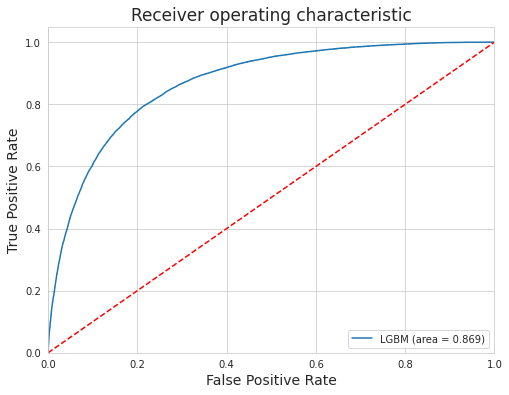

In [ ]:
oc.roc_curve_plot(y_folds,preds_folds)


In [ ]:
#New:
roc_auc_score(y_folds,preds_folds)

0.8692338137106796

In [ ]:
#roc_auc_score(y_folds,preds_folds)
#0.8708353816266694 (old)

## ➡️ Submission

Here we read the unlabeled test data and pass it through the same pipeline as the training data to predict diabetes_mellitus as a 1 or a 0. 

In [ ]:
# re-read df
wids_test_df = pd.read_csv(filepath+'UnlabeledWiDS2021.csv',index_col=0)


#Implement pipeline to test dataframe
wids_test_df = drop_columns(remove_percent_missing(fix_data_types(cat_cols, 
                                                           bin_cols, num_cols, 
                                                           ethnicity_gender_bmi(add_bmi(wids_test_df))), 0.91), True)

wids_test_df = pd.get_dummies(data=wids_test_df, columns=cat_cols+bin_cols, drop_first=True)

#wids_test_df = impute_missing_values(wids_train_df, wids_test_df)

In [ ]:
extra_test_cols = list(set(wids_test_df.columns).difference(set(train_df.columns)))
extra_test_cols.remove('encounter_id')
extra_test_cols

[]

In [ ]:
missing_cols_test = list(set(train_df.columns).difference(set(wids_test_df.columns)))
missing_cols_test.remove('diabetes_mellitus')


In [ ]:
wids_test_df[missing_cols_test] = 0

In [ ]:
wids_test_df.drop(extra_test_cols, axis=1, inplace=True)

In [ ]:
def predict_for_submission(fileversion,model,te,ids_list,features):
    filename = "Submissions/GirlsGoneWireless_Submission_v" + str(fileversion) + ".csv"
    if target in te.columns:
        te.drop([target],axis=1,inplace=True)
    te_preds=model.predict(te[features])
    print(te_preds[1:2])

    submit=pd.DataFrame()
    submit['encounter_id'] = ids_list
    submit['diabetes_mellitus'] = te_preds
    submit.to_csv(filepath+filename,index=False)
    return submit

In [ ]:
# update version number here
version_num=53

In [ ]:
target="diabetes_mellitus"
submit=predict_for_submission(version_num,clf,
                              wids_test_df[tr.columns.tolist()],
                              wids_test_df['encounter_id'].tolist(), tr.columns.tolist())

[0.06869624]


# Pending



### New todos:
- xgboost
- Bins:
  - age
  - hospital id (maybe)
- Run with 90% for missing data ✅
- higher percentages - from 90 to 92, 94....`[Ana working on this on v6]`

